In [2]:
! pip install Sastrawi
! pip install tqdm
! pip install indonesian-number-normalizer

In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from indonesian_number_normalizer import create_normalizer
from tqdm import tqdm


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
normalizer = create_normalizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv(r'D:\SKRIPSI\skripsi_2025\fix_dataset\berita_terdahulu.csv')
df

,Title,Content,Sumber,Link,Created_at,label
0,Apakah Eropa Kembali Akan Dilanda Krisis Moneter?,Janji-janji pemilu yang diberikan oleh kubu sa...,Detik,https://news.detik.com/dw/d-7413130/apakah-ero...,"Jumat, 28 Jun 2024 13:49 WIB",positif
1,"Krisis Moneter: Pengertian, Penyebab, dan Damp...",Krisis moneter yang melanda Indonesia pada tah...,Detik,https://finance.detik.com/moneter/d-7090380/kr...,"Kamis, 14 Des 2023 19:45 WIB",negatif
2,"Prabowo Bicara Pertahanan Ekonomi, Ungkit Kris...",Bakal capres Prabowo Subianto menyampaikan pem...,Detik,https://news.detik.com/pemilu/d-7026179/prabow...,"Rabu, 08 Nov 2023 18:01 WIB",positif
3,Sejarah Budi Daya Bunga Kota Batu dan Krisis M...,"Sebelum dikenal sebagai Kota Wisata, masyaraka...",Detik,https://www.detik.com/jatim/wisata/d-7079713/s...,"Jumat, 08 Des 2023 20:08 WIB",positif
4,Memori Taman Puring: Tempat Para Korban PHK Er...,"Terletak di kawasan Kebayoran Baru, Jakarta Se...",Detik,https://finance.detik.com/berita-ekonomi-bisni...,"Jumat, 22 Sep 2023 08:39 WIB",negatif
...,...,...,...,...,...,...
1545,"Resesi Sudah Hampir Pasti, Bakal Separah 1998 ...","Jakarta, CNBC Indonesia - Menteri Keuangan Sri...",CNBC,https://www.cnbcindonesia.com/news/20220927112...,9/27/2022 12:30,negatif
1546,"7 Negara di Ujung Tanduk, Inflasi Tinggi & Ter...","Jakarta, CNBC Indonesia - Krisis global yang t...",CNBC,https://www.cnbcindonesia.com/news/20220913080...,9/13/2022 8:20,negatif
1547,"Dunia di Bibir Jurang Krisis, Lebih Ngeri dari...","Jakarta, CNBC Indonesia - Lonjakan inflasi dan...",CNBC,https://www.cnbcindonesia.com/news/20220621124...,6/21/2022 14:55,negatif
1548,"Jokowi Cemaskan Resesi, Indonesia Bakal Kena?","Jakarta, CNBC Indonesia - Presiden Joko Widodo...",CNBC,https://www.cnbcindonesia.com/news/20220511142...,5/11/2022 16:20,negatif


In [4]:
df = df[['Title', 'Content', 'Created_at', 'label']]

In [5]:
df = df.drop_duplicates(subset=['Content', 'label'])
print(f"Dataset setelah dibersihkan memiliki {len(df)} baris")

Dataset setelah dibersihkan memiliki 1339 baris


In [6]:
df

,Title,Content,Created_at,label
0,Apakah Eropa Kembali Akan Dilanda Krisis Moneter?,Janji-janji pemilu yang diberikan oleh kubu sa...,"Jumat, 28 Jun 2024 13:49 WIB",positif
1,"Krisis Moneter: Pengertian, Penyebab, dan Damp...",Krisis moneter yang melanda Indonesia pada tah...,"Kamis, 14 Des 2023 19:45 WIB",negatif
2,"Prabowo Bicara Pertahanan Ekonomi, Ungkit Kris...",Bakal capres Prabowo Subianto menyampaikan pem...,"Rabu, 08 Nov 2023 18:01 WIB",positif
3,Sejarah Budi Daya Bunga Kota Batu dan Krisis M...,"Sebelum dikenal sebagai Kota Wisata, masyaraka...","Jumat, 08 Des 2023 20:08 WIB",positif
4,Memori Taman Puring: Tempat Para Korban PHK Er...,"Terletak di kawasan Kebayoran Baru, Jakarta Se...","Jumat, 22 Sep 2023 08:39 WIB",negatif
...,...,...,...,...
1536,"Meski Dilanda Demo, Rupiah Menguat 3 Hari vs R...","Jakarta, CNBC Indonesia - Nilai tukar rupiah m...",10/7/2020 19:15,positif
1537,"Cadev RI Anjlok & Demo, Bikin Rupiah KO vs Dol...","Jakarta, CNBC Indonesia - Nilai tukar rupiah m...",10/7/2020 17:12,negatif
1540,"Muncul Tanda-Tanda Ekonomi RI Terancam Gawat, ...","Jakarta, CNBC Indonesia - Kondisi ekonomi RI d...",10/5/2024 21:45,positif
1546,"7 Negara di Ujung Tanduk, Inflasi Tinggi & Ter...","Jakarta, CNBC Indonesia - Krisis global yang t...",9/13/2022 8:20,negatif


PRE-PROCESSING DATA

In [7]:
def cleaning(teks):
    if not isinstance(teks, str):
        return ""
    teks = re.sub(r'<.*?>', ' ', teks)
    teks = re.sub(r'https?://\S+|www\.\S+', ' ', teks)
    teks = re.sub(r'ADVERTISEMENT.*?CONTENT', ' ', teks, flags=re.IGNORECASE | re.DOTALL)
    teks = re.sub(r'[^\w\s\d]', ' ', teks)
    teks = re.sub(r'\s+', ' ', teks).strip()
    return teks
df['cleaned_text'] = df['Content'].fillna('').apply(cleaning)

In [8]:
def case_folding(teks):
    return teks.lower()
df['case_folded_text'] = df['cleaned_text'].apply(case_folding)

In [9]:
def normalisasi(teks):
    # Normalisasi angka (misalnya "100 juta" menjadi "seratus juta")
    try:
        # Gunakan normalize_text dari instance normalizer
        teks = normalizer.normalize_text(teks)
    except Exception as e:
        print(f"Error saat normalisasi angka: {e}")
        pass
    slang_dict = {
        'dgn': 'dengan',
        'tdk': 'tidak',
        'tsb': 'tersebut',
        'utk': 'untuk',
        'spy': 'supaya',
        'krn': 'karena',
        'jg': 'juga',
        'bs': 'bisa',
        'sdh': 'sudah',
        'blm': 'belum',
        'org': 'orang',
        'yg': 'yang',
        'sy': 'saya',
        'dlm': 'dalam',
        'pd': 'pada',
        'dr': 'dari',
        'kmrn': 'kemarin',
        'skrg': 'sekarang',
        'hrs': 'harus',
        'msk': 'masuk',
        'trs': 'terus',
        'tp': 'tapi',
        'kalo': 'kalau',
        'gak': 'tidak',
        'ga': 'tidak',
        'ngga': 'tidak',
        'gk': 'tidak',
        'thn': 'tahun',
        'bln': 'bulan',
        'sblm': 'sebelum',
        'stlh': 'setelah',
        'milyar': 'miliar',
        'trilliun': 'triliun',
        'jt': 'juta',
        'rb': 'ribu',
        '%': 'persen',
        'usd': 'dolar amerika',
        'rupiah': 'rupiah',
        'rp': 'rupiah',
        ',': 'koma',
    }
    
    # Buat pattern regex untuk seluruh kamus sekaligus (lebih efisien)
    pattern = r'\b(' + '|'.join(slang_dict.keys()) + r')\b'
    
    # Fungsi replacement yang menggunakan kamus
    def replace_match(match):
        return slang_dict[match.group(0)]
    
    # Ganti semua kata slang dalam satu kali proses
    return re.sub(pattern, replace_match, teks)
df['normalized_text'] = df['case_folded_text'].apply(normalisasi)

In [10]:
def tokenzing(teks):
    return word_tokenize(teks)
df['tokens'] = df['normalized_text'].apply(tokenzing)

In [11]:
indo_stopwords = set(stopwords.words('indonesian'))
tambahan_stopwords = {
    'ya', 'juga', 'dari', 'di', 'ke', 'pada', 'untuk', 'bagi', 'dan', 'atau', 
    'tapi', 'namun', 'dengan', 'secara', 'oleh', 'karena', 'sehingga', 'agar',
    'sebab', 'jika', 'bila', 'adalah', 'ini', 'itu', 'detik', 'kata', 'dalam',
    'saat', 'akan', 'tidak', 'yang', 'belum', 'sudah', 'telah', 'bisa', 'dapat', 
    'nya', 'pak', 'bu', 'hal', 'pun'
}
indo_stopwords.update(tambahan_stopwords)
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in indo_stopwords]
df['filtered_tokens'] = df['tokens'].apply(remove_stopwords)

In [12]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming(tokens):
    return [stemmer.stem(word) for word in tokens]
df['stemmed_tokens'] = [stemming(tokens) for tokens in tqdm(df['filtered_tokens'], desc="Stemming")]
df['stemmed_text'] = df['stemmed_tokens'].apply(lambda x: ' '.join(x))

Stemming: 100%|██████████| 1339/1339 [18:08<00:00,  1.23it/s] 


In [14]:
df['processed_content'] = df['stemmed_text']
display(df[['Title', 'stemmed_text', 'Created_at', 'label']].head())
#df_display = df[['Title', 'processed_content', 'Created_at', 'label']]
#print(df_display.head())

,Title,stemmed_text,Created_at,label
0,Apakah Eropa Kembali Akan Dilanda Krisis Moneter?,janji janji milu kubu sayap kanan sayap kiri p...,"Jumat, 28 Jun 2024 13:49 WIB",positif
1,"Krisis Moneter: Pengertian, Penyebab, dan Damp...",krisis moneter landa indonesia ribu sembilan r...,"Kamis, 14 Des 2023 19:45 WIB",negatif
2,"Prabowo Bicara Pertahanan Ekonomi, Ungkit Kris...",capres prabowo subianto pikir polemik moneter ...,"Rabu, 08 Nov 2023 18:01 WIB",positif
3,Sejarah Budi Daya Bunga Kota Batu dan Krisis M...,kenal kota wisata masyarakat kota batu tani me...,"Jumat, 08 Des 2023 20:08 WIB",positif
4,Memori Taman Puring: Tempat Para Korban PHK Er...,letak kawasan kebayoran jakarta selatan taman ...,"Jumat, 22 Sep 2023 08:39 WIB",negatif


In [15]:
preprocessing_new_file = r'D:\SKRIPSI\skripsi_2025\fix_dataset\berita_terdahulu_preprocessing.csv'
preprocessing_new_columns = ['Title', 'Content', 'stemmed_text', 'Created_at', 'label']
df[preprocessing_new_columns].to_csv(preprocessing_new_file, index=False)
print(f"Hasil preprocessing berita terkini disimpan ke {preprocessing_new_file}")

Hasil preprocessing berita terkini disimpan ke D:\SKRIPSI\skripsi_2025\fix_dataset\berita_terdahulu_preprocessing.csv


PENGELOMPOKAN FAKTOR

In [65]:
# Kata kunci untuk setiap kategori
kata_kunci = {
    'suku_bunga': [
        'suku bunga', 'interest rate', 'bi rate', 'bunga', 'bi 7drrr', 'rate', 
        'interest', 'bunga pinjaman', 'kredit', 'pinjaman', 'kpr', 'deposito', 
        'tabungan', 'kebijakan moneter', 'pemangkasan bunga', 'kenaikan bunga', 
        'penurunan bunga', 'bunga acuan', 'fed rate', 'the fed', 'bank sentral', 
        'bank indonesia', 'inflasi', 'yield', 'obligasi', 'federal reserve',
        'persen', 'persentase', 'basis poin', 'bps', 'naik', 'turun', 'tetap',
        'tingkat bunga', 'acuan moneter', 'kebijakan moneter', 'surat utang'
    ],
    'impor': [
        'impor', 'import', 'bea masuk', 'tarif impor', 'pajak impor', 'barang impor', 
        'komoditas impor', 'produk impor', 'ketergantungan impor', 'pembatasan impor',
        'larangan impor', 'kuota impor', 'izin impor', 'nilai impor', 'volume impor', 
        'impor beras', 'impor gula', 'impor daging', 'impor bbm', 'impor gandum', 
        'impor kedelai', 'impor bawang', 'impor garam', 'impor jagung',
        'importir', 'barang masuk', 'masuk negara', 'kebutuhan dalam negeri', 
        'ketergantungan', 'kuota', 'belanja luar negeri', 'pembelian luar negeri',
        'pelabuhan', 'bongkar muat', 'container', 'kontainer', 'harmonisasi'
    ],
    'ekspor': [
        'ekspor', 'export', 'komoditas ekspor', 'produk ekspor', 'nilai ekspor', 
        'volume ekspor', 'pasar ekspor', 'tujuan ekspor', 'pertumbuhan ekspor', 
        'penurunan ekspor', 'kenaikan ekspor', 'ekspor sawit', 'ekspor batu bara', 
        'ekspor nikel', 'ekspor karet', 'ekspor tekstil', 'ekspor manufaktur', 
        'ekspor pertanian', 'ekspor perikanan', 'ekspor kayu', 'eksportir', 
        'perdagangan internasional', 'neraca perdagangan', 'surplus perdagangan', 
        'defisit perdagangan','barang keluar', 'pasar global', 'pasar dunia', 'pengiriman barang',
        'devisa', 'penghasil devisa', 'penerimaan negara', 'komoditas unggulan',
        'nilai tambah', 'pengapalan', 'negara tujuan', 'kepabeanan', 'hilirisasi'
    ]
}

In [66]:
stemmed_kata_kunci = {}
for kategori, keywords in kata_kunci.items():
    stemmed_keywords = []
    for keyword in keywords:
        if ' ' in keyword:  # Kata majemuk
            stemmed_parts = [stemmer.stem(word) for word in keyword.split()]
            stemmed_keywords.append(' '.join(stemmed_parts))
        else:  # Kata tunggal
            stemmed_keywords.append(stemmer.stem(keyword))
    stemmed_kata_kunci[kategori] = stemmed_keywords

# Fungsi untuk memeriksa apakah teks mengandung kata kunci dari kategori tertentu
# Perbaikan: Menggunakan regex word boundary untuk pencocokan kata yang lebih akurat
def cek_kategori(teks, kategori_keywords):
    matches = []
    for keyword in kategori_keywords:
        if ' ' in keyword:  # Kata majemuk - cek sebagai frasa
            if keyword in teks:
                matches.append(keyword)
        else:  # Kata tunggal - gunakan regex dengan word boundary
            pattern = r'\b' + re.escape(keyword) + r'\b'
            if re.search(pattern, teks):
                matches.append(keyword) 
    return matches

# Kategorisasi berita dengan pencatatan kata kunci yang cocok
for kategori, keywords in stemmed_kata_kunci.items():
    df[f"{kategori}_keywords"] = df['stemmed_text'].apply(lambda x: cek_kategori(x, keywords))
    df[kategori] = df[f"{kategori}_keywords"].apply(lambda x: len(x) > 0)

In [67]:
#Membuat kolom faktor
def get_faktor(row):
    faktor = []
    for kategori in stemmed_kata_kunci.keys():
        if row[kategori]:
            faktor.append(kategori)
    return faktor
df['faktor'] = df.apply(get_faktor, axis=1)

# Menambahkan kolom yang mencatat kata kunci spesifik yang ditemukan
def get_keyword_details(row):
    details = {}
    for kategori in stemmed_kata_kunci.keys():
        if row[kategori] and len(row[f"{kategori}_keywords"]) > 0:
            details[kategori] = row[f"{kategori}_keywords"]
    return details
df['keyword_details'] = df.apply(get_keyword_details, axis=1)

print("\nJumlah berita per kategori:")
for kategori in stemmed_kata_kunci.keys():
    jumlah = df[kategori].sum()
    print(f"{kategori}: {jumlah} berita")


Jumlah berita per kategori:
suku_bunga: 1246 berita
impor: 468 berita
ekspor: 544 berita


In [68]:
df['jumlah_kategori'] = df[list(stemmed_kata_kunci.keys())].sum(axis=1)
print(f"\nBerita yang tidak masuk kategori: {len(df[df['jumlah_kategori'] == 0])}")
print(f"Berita yang masuk 1 kategori: {len(df[df['jumlah_kategori'] == 1])}")
print(f"Berita yang masuk 2 kategori: {len(df[df['jumlah_kategori'] == 2])}")
print(f"Berita yang masuk 3 kategori: {len(df[df['jumlah_kategori'] == 3])}")


Berita yang tidak masuk kategori: 61
Berita yang masuk 1 kategori: 601
Berita yang masuk 2 kategori: 374
Berita yang masuk 3 kategori: 303


In [71]:
# Menghapus berita yang tidak masuk ke kategori apapun
df_filtered = df[df['jumlah_kategori'] > 0].copy()
print(f"Jumlah berita setelah menghapus yang tidak berkategori: {len(df_filtered)}")

Jumlah berita setelah menghapus yang tidak berkategori: 1278


In [ ]:
# # Menyimpan hasil kategori ke file CSV baru
# output_file = 'berita_terkategori.csv'
# # Mengonversi kolom faktor dan keyword_details (dict/list) menjadi string agar bisa disimpan di CSV
# df_filtered['faktor_str'] = df_filtered['faktor'].apply(lambda x: str(x))
# df_filtered['keyword_details_str'] = df_filtered['keyword_details'].apply(lambda x: str(x))
# df_output = df_filtered[['Title', 'Content', 'Created_at', 'label', 'faktor_str', 'jumlah_kategori', 'keyword_details_str']]
# df_output.to_csv(output_file, index=False)
# print(f"Hasil pengelompokan telah disimpan ke {output_file}")

Hasil pengelompokan telah disimpan ke berita_terkategori.csv


In [72]:
preprocessing_file = (r'D:\SKRIPSI\skripsi_2025\fix_dataset\berita_preprocessing.csv')
preprocessing_columns = ['Title', 'Content','stemmed_text', 'faktor_str', 'label', 'Created_at']
df_filtered[preprocessing_columns].to_csv(preprocessing_file, index=False)
print(f"Hasil preprocessing (hanya berita berkategori) disimpan ke {preprocessing_file}")

Hasil preprocessing (hanya berita berkategori) disimpan ke D:\SKRIPSI\skripsi_2025\fix_dataset\berita_preprocessing.csv


In [ ]:
# for kategori in stemmed_kata_kunci.keys():
#     kategori_file = f'berita_{kategori}.csv'
#     df_kategori = df[df[kategori]]
#     df_kategori['faktor_str'] = df_kategori['faktor'].apply(lambda x: str(x))
#     df_kategori['keyword_details_str'] = df_kategori['keyword_details'].apply(lambda x: str(x))
#     df_kategori[['Title', 'Content', 'Created_at', 'label', 'faktor_str', 'keyword_details_str']].to_csv(kategori_file, index=False)
#     print(f"Berita kategori {kategori} disimpan ke {kategori_file}")

Berita kategori suku_bunga disimpan ke berita_suku_bunga.csv
Berita kategori impor disimpan ke berita_impor.csv
Berita kategori ekspor disimpan ke berita_ekspor.csv


<ipython-input-54-429e7a47a91e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kategori['faktor_str'] = df_kategori['faktor'].apply(lambda x: str(x))
<ipython-input-54-429e7a47a91e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kategori['keyword_details_str'] = df_kategori['keyword_details'].apply(lambda x: str(x))


In [55]:
print("\nSampel berita dari setiap kategori:")
for kategori in stemmed_kata_kunci.keys():
    print(f"\n=== SAMPEL BERITA {kategori.upper()} ===")
    if df[df[kategori]].shape[0] > 0:
        sampel = df[df[kategori]].sample(min(3, df[df[kategori]].shape[0]))
        for idx, row in sampel.iterrows():
            print(f"Judul: {row['Title']}")
            print(f"Tanggal: {row['Created_at']}")
            print(f"Label: {row['label']}")
            print(f"Faktor: {row['faktor']}")
            print(f"Kata kunci yang ditemukan: {row['keyword_details']}")
            print("---")
    else:
        print("Tidak ada berita dalam kategori ini.")



Sampel berita dari setiap kategori:

=== SAMPEL BERITA SUKU_BUNGA ===
Judul: 3 Saran Ngawur IMF yang Pernah Bikin RI Masuk 'ICU'
Tanggal: Selasa, 04 Jul 2023 16:49 WIB
Label: negatif
Faktor: ['suku_bunga', 'ekspor']
Kata kunci yang ditemukan: {'suku_bunga': ['suku bunga', 'bunga', 'pinjam', 'bijak moneter', 'bank indonesia', 'naik', 'turun', 'bijak moneter'], 'ekspor': ['ekspor']}
---
Judul: Subsidi BBM-LPG Diramal Bengkak, Sri Mulyani Beberkan Sebabnya
Tanggal: 7/9/2024 6:55
Label: negatif
Faktor: ['suku_bunga']
Kata kunci yang ditemukan: {'suku_bunga': ['naik', 'turun']}
---
Judul: Prabowo Mulai Kerja! Deflasi Langsung Ganti ke Inflasi, Tanda Baik?
Tanggal: 10/31/2024 12:15
Label: positif
Faktor: ['suku_bunga']
Kata kunci yang ditemukan: {'suku_bunga': ['bank indonesia', 'inflasi', 'bps', 'naik', 'turun']}
---

=== SAMPEL BERITA IMPOR ===
Judul: RI Doyan Gorengan Tempe-Tahu, Tapi Sayang Impor Kedelai Sampai 90%
Tanggal: 9/9/2024 14:25
Label: negatif
Faktor: ['suku_bunga', 'impor']
K

WORD EMBEDDING

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from tqdm import tqdm

In [2]:
! pip install gensim nltk scikit-learn tqdm matplotlib seaborn

  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2


In [3]:
from gensim.models import FastText
import nltk
nltk.download('punkt', quiet=True)

True

In [7]:
df = pd.read_csv(r'D:\SKRIPSI\skripsi_2025\fix_dataset\berita_preprocessing.csv')
df

,Title,Content,stemmed_text,faktor_str,label,Created_at
0,Apakah Eropa Kembali Akan Dilanda Krisis Moneter?,Janji-janji pemilu yang diberikan oleh kubu sa...,janji janji milu kubu sayap kanan sayap kiri p...,['suku_bunga'],positif,"Jumat, 28 Jun 2024 13:49 WIB"
1,"Krisis Moneter: Pengertian, Penyebab, dan Damp...",Krisis moneter yang melanda Indonesia pada tah...,krisis moneter landa indonesia ribu sembilan r...,['suku_bunga'],negatif,"Kamis, 14 Des 2023 19:45 WIB"
2,"Prabowo Bicara Pertahanan Ekonomi, Ungkit Kris...",Bakal capres Prabowo Subianto menyampaikan pem...,capres prabowo subianto pikir polemik moneter ...,['suku_bunga'],positif,"Rabu, 08 Nov 2023 18:01 WIB"
3,Sejarah Budi Daya Bunga Kota Batu dan Krisis M...,"Sebelum dikenal sebagai Kota Wisata, masyaraka...",kenal kota wisata masyarakat kota batu tani me...,['suku_bunga'],positif,"Jumat, 08 Des 2023 20:08 WIB"
4,Kebijakan Prabowo Hapus Utang UMKM Pertanian A...,Kebijakan Presiden RI Prabowo Subianto untuk m...,bijak presiden ri prabowo subianto hapus utang...,['suku_bunga'],positif,"Rabu, 06 Nov 2024 12:35 WIB"
...,...,...,...,...,...,...
1273,"Harga Bensin Tembus Rp 24.000/liter, Turki Ken...","Jakarta, CNBC Indonesia - Turki mengalami 'tsu...",jakarta cnbc indonesia turki alami tsunami inf...,"['suku_bunga', 'impor', 'ekspor']",positif,6/30/2022 13:30
1274,"Cadev RI Anjlok & Demo, Bikin Rupiah KO vs Dol...","Jakarta, CNBC Indonesia - Nilai tukar rupiah m...",jakarta cnbc indonesia nilai tukar rupiah lema...,"['suku_bunga', 'impor', 'ekspor']",negatif,10/7/2020 17:12
1275,"Muncul Tanda-Tanda Ekonomi RI Terancam Gawat, ...","Jakarta, CNBC Indonesia - Kondisi ekonomi RI d...",jakarta cnbc indonesia kondisi ekonomi ri nila...,"['suku_bunga', 'ekspor']",positif,10/5/2024 21:45
1276,"7 Negara di Ujung Tanduk, Inflasi Tinggi & Ter...","Jakarta, CNBC Indonesia - Krisis global yang t...",jakarta cnbc indonesia krisis global picu pand...,"['suku_bunga', 'impor', 'ekspor']",negatif,9/13/2022 8:20


In [12]:
def tokenize_text(text):
    if isinstance(text, str):
        return text.split()
    return []
tokenized_docs = [tokenize_text(text) for text in df['stemmed_text']]

for i in range(min(5, len(tokenized_docs))):
    print(f"Dokumen {i+1}: {tokenized_docs[i][:10]}...")

Dokumen 1: ['janji', 'janji', 'milu', 'kubu', 'sayap', 'kanan', 'sayap', 'kiri', 'prancis', 'sulit']...
Dokumen 2: ['krisis', 'moneter', 'landa', 'indonesia', 'ribu', 'sembilan', 'ratus', 'sembilan', 'puluh', 'delapan']...
Dokumen 3: ['capres', 'prabowo', 'subianto', 'pikir', 'polemik', 'moneter', 'global', 'pengaruh', 'nilai', 'rupiah']...
Dokumen 4: ['kenal', 'kota', 'wisata', 'masyarakat', 'kota', 'batu', 'tani', 'membudidayakan', 'bunga', 'mata']...
Dokumen 5: ['bijak', 'presiden', 'ri', 'prabowo', 'subianto', 'hapus', 'utang', 'macet', 'usaha', 'mikro']...


In [14]:
# Melatih model FastText
vector_size = 100  # dimensi vektor
window = 5         # ukuran jendela konteks
min_count = 2      # frekuensi kata minimum
workers = 4        # jumlah thread
sg = 1             # Skip-gram (1) vs CBOW (0)
epochs = 20        # jumlah epoch pelatihan

# Latih model
model_ft = FastText(
    tokenized_docs,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    sg=sg,
    epochs=epochs
)

In [ ]:
# memeriksa hasil model
kata_kunci = ['krisis', 'ekonomi', 'moneter', 'inflasi', 'ekspor', 'impor', 'bunga'] #periksa kata yang mirip
print("\nKata-kata yang serupa dengan kata kunci:")
for kata in kata_kunci:
    try:
        similar_words = model_ft.wv.most_similar(kata, topn=5)
        print(f"\nKata yang mirip dengan '{kata}':")
        for word, similarity in similar_words:
            print(f"  {word}: {similarity:.4f}")
    except KeyError:
        print(f"\n'{kata}' tidak ditemukan dalam kosakata model")


Kata-kata yang serupa dengan kata kunci:

Kata yang mirip dengan 'krisis':
  delapankrisis: 0.7908
  krismo: 0.7770
  krismon: 0.7257
  crisis: 0.7178
  multidimensi: 0.6616

Kata yang mirip dengan 'ekonomi':
  geoekonomi: 0.7746
  imfmenurut: 0.7032
  tumbuh: 0.6712
  makroekonomi: 0.6699
  turbulensi: 0.6492

Kata yang mirip dengan 'moneter':
  monetari: 0.6730
  nonmoneter: 0.6643
  monetary: 0.6129
  kebijakanpada: 0.5833
  bijak: 0.5800

Kata yang mirip dengan 'inflasi':
  asinflasi: 0.8923
  disinflasi: 0.7915
  hiperinflasi: 0.7382
  landai: 0.7020
  inti: 0.6999

Kata yang mirip dengan 'ekspor':
  eksportir: 0.7576
  nonmigas: 0.7209
  eksporpelemahan: 0.6755
  impor: 0.6083
  migas: 0.6018

Kata yang mirip dengan 'impor':
  imporhal: 0.7387
  import: 0.7158
  importir: 0.6879
  importer: 0.6866
  importasi: 0.6791

Kata yang mirip dengan 'bunga':
  suku: 0.9005
  acu: 0.6791
  mangkas: 0.6776
  fedthe: 0.6698
  fed: 0.6624


In [ ]:
# konversi dokumen ke vektor
def get_document_vector(doc_tokens, model):
    """Mengkonversi dokumen (list token) menjadi vektor dengan rata-rata vektor token"""
    vec = np.zeros(model.vector_size)
    count = 0
    for token in doc_tokens:
        try:
            vec += model.wv[token]
            count += 1
        except KeyError:
            continue
    if count > 0:
        vec /= count
    return vec
# konversi dokumen ke vektor
doc_vectors = []
for doc in tqdm(tokenized_docs):
    doc_vectors.append(get_document_vector(doc, model_ft))
# mengubah ke array numpy
doc_vectors = np.array(doc_vectors)
print(f"Bentuk vektor dokumen: {doc_vectors.shape}")

100%|██████████| 1278/1278 [00:02<00:00, 594.67it/s]

Bentuk vektor dokumen: (1278, 100)


In [31]:
# simpan model dan vektor
model_ft.save("model_fasttext_berita.bin")
with open("doc_vectors_fasttext.pkl", "wb") as f:
    pickle.dump(doc_vectors, f)

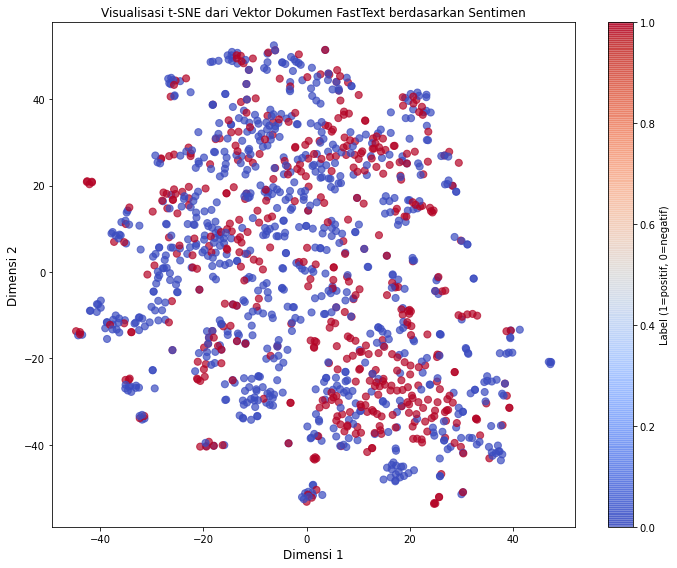

In [32]:
# visualisasi dengan t-sne
from sklearn.manifold import TSNE

label_map = {'positif': 1, 'negatif': 0} #split berdasarkan label sentimen
y = df['label'].map(label_map).values
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
vectors_tsne = tsne.fit_transform(doc_vectors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    vectors_tsne[:, 0], 
    vectors_tsne[:, 1], 
    c=y, 
    cmap='coolwarm', 
    alpha=0.7,
    s=50
)
plt.colorbar(scatter, label='Label (1=positif, 0=negatif)')
plt.title('Visualisasi t-SNE dari Vektor Dokumen FastText berdasarkan Sentimen', fontsize=12)
plt.xlabel('Dimensi 1', fontsize=12)
plt.ylabel('Dimensi 2', fontsize=12)
plt.tight_layout()
plt.show()